# Model Generation

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import configparser
import pandas as pd

import torch
import pytorch_lightning as pl

from pynas.core.population import Population
from datasets.RawClassifier.loader import RawClassifierDataModule

# Define dataset module
root_dir = '/Data_large/marine/PythonProjects/OtherProjects/lpl-PyNas/data/RawClassifier'
dm = RawClassifierDataModule(root_dir, batch_size=4, num_workers=2, transform=None)

config = configparser.ConfigParser()
config.read('config.ini')
def setting():
    pd.set_option('display.max_colwidth', None)
    # Logging
    logs_directory = str(config['GA']['logs_dir_GA'])
    # Torch stuff
    seed = config.getint(section='Computation', option='seed')
    pl.seed_everything(seed=seed, workers=True)  # For reproducibility
    torch.set_float32_matmul_precision("medium")  # to make lightning happy
setting()

Seed set to 42


-----------The batch size of the data to be loaded in the model is: 4-----------
-----------The learning rate of the data to be loaded in the model is: 0.001-----------


In [3]:
# Model parameters
max_layers = 3
max_iter = int(config['GA']['max_iterations'])
# GA parameters
n_individuals = int(config['GA']['population_size'])
mating_pool_cutoff = float(config['GA']['mating_pool_cutoff'])
mutation_probability = float(config['GA']['mutation_probability'])

pop = Population(n_individuals=20, max_layers=max_layers, dm=dm, max_parameters=400_000)

In [4]:
pop.initial_poll()

Generating Population:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Population: 100%|██████████| 20/20 [00:06<00:00,  3.26it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                       | Params | Mode 
------------------------------------------------------------------------
0 | model            | Sequential                 | 4.3 M  | train
1 | loss_fn          | CrossEntropyLoss           | 0      | train
2 | accuracy         | MulticlassAccuracy         | 0      | train
3 | f1_score         | MulticlassF1Score          | 0      | train
4 | mcc              | MulticlassMatthewsCorrCoef | 0      | train
5 | conf_matrix      | MulticlassConfusionMatrix  | 0      | train
6 | conf_matrix_pred | MulticlassConfusionMatrix  | 0      | train
------------------------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.012    Total estimated model params size (MB)
38        Modules in train mo

Training individual 19/20


/home/vessel/anaconda3/envs/pynas/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 14: 100%|██████████| 8/8 [00:06<00:00,  1.28it/s, v_num=54, train_loss=0.585, train_accuracy=0.694, train_f1_score=0.650, train_mcc=0.535]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 8/8 [00:06<00:00,  1.23it/s, v_num=54, train_loss=0.585, train_accuracy=0.694, train_f1_score=0.650, train_mcc=0.535]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 28/28 [00:08<00:00,  3.12it/s]


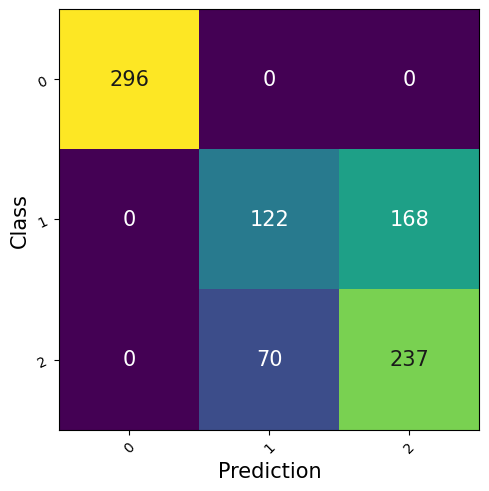

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            fps            │     589.935302734375      │
│       test_accuracy       │     0.734043300151825     │
│       test_f1_score       │    0.7190351486206055     │
│         test_loss         │     0.415016770362854     │
│         test_mcc          │    0.6153704524040222     │
└───────────────────────────┴───────────────────────────┘

In [21]:
pop.train_generation(task='classification', lr=0.001, epochs=15, batch_size=32)

In [23]:
pop.evolve(mating_pool_cutoff=mating_pool_cutoff, mutation_probability=0.85, k_best=1, n_random=3)

In [24]:
pop.df


,Generation,Layers,Fitness,Metric,FPS,Params
0,3,"[{'layer_type': 'MBConv', 'expansion_factor': '4', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 7, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '4', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}]",3.065008,0.73479,559.272278,9347
1,3,"[{'layer_type': 'ConvSE', 'out_channels_coefficient': 6, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '6', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.15}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,7707
2,3,"[{'layer_type': 'ConvSE', 'out_channels_coefficient': 8, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ResNetBlock', 'reduction_factor': '2', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 12, 'activation': 'GELU'}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,57019
3,3,"[{'layer_type': 'MBConvNoRes', 'expansion_factor': '6', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.31}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvAct', 'out_channels_coefficient': 7, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.000000,NaN,NaN,743
4,3,"[{'layer_type': 'MBConvNoRes', 'expansion_factor': '3', 'activation': 'ReLU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'ConvSE', 'out_channels_coefficient': 4, 'kernel_size': '3', 'stride': '1', 'padding': '2', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.27}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,499
5,3,"[{'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 5, 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '5', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvAct', 'out_channels_coefficient': 5, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}]",0.000000,NaN,NaN,20549
6,3,"[{'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 5, 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'MBConv', 'expansion_factor': '4', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '3', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}]",0.000000,NaN,NaN,12677
7,3,"[{'layer_type': 'MBConvNoRes', 'expansion_factor': '4', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ResNetBlock', 'reduction_factor': '3', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'MBConv', 'expansion_factor': '5', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,701
8,3,"[{'layer_type': 'DenseNetBlock', 'out_channels_coefficient': 10, 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 9, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}, {'layer_type': 'Dropout', 'dropout_rate': 0.13}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,70897
9,3,"[{'layer_type': 'ResNetBlock', 'reduction_factor': '4', 'activation': 'ReLU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'ConvBnAct', 'out_channels_coefficient': 9, 'kernel_size': '3', 'stride': '1', 'padding': '1', 'activation': 'GELU'}, {'layer_type': 'MaxPool'}, {'layer_type': 'MBConv', 'expansion_factor': '6', 'activation': 'GELU'}, {'layer_type': 'AvgPool'}]",0.000000,NaN,NaN,16447


# To Be Rewritten with Bash Logic:

This part of the code train the whole population one individual at the time and can be performed on single individuals in parallel. Using bash we can run parallel training. 

# Inference

Using the evaluated and saved model. We use the traced pytroch model (.pt) to load and execute inference.

In [ ]:
# Load the saved TorchScript model and test with a dummy input.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

save_path = "model_and_architecture.pt"
loaded_model = torch.jit.load(save_path, map_location=device)
loaded_model.eval()

# Ensure input is moved to the correct device
example_input = torch.randn(1, *dm.input_shape).to(device)
example_input = example_input.to(device)

with torch.no_grad():
    output = loaded_model(example_input)
print("Output from the loaded model:", output)